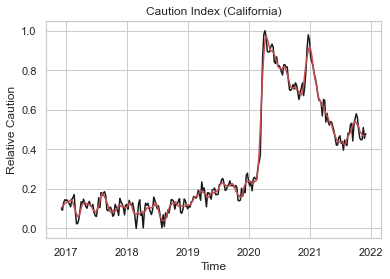

In [1384]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#from matplotlib.dates import DateFormatter
#import matplotlib.dates as mdates
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
#import datetime
from scipy import stats
from scipy.signal import savgol_filter
from scipy.optimize import curve_fit
from statsmodels.tsa.stattools import grangercausalitytests
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.vector_ar.var_model import VAR
from statsmodels.tsa.arima.model import ARIMA
import statsmodels.api as sm
from pmdarima.arima import auto_arima

%matplotlib inline

def mape(actual, fc): 
    actual, fc = np.array(actual), np.array(fc)
    return np.mean(np.abs((actual - fc) / actual)) * 100

def func_exp(t, tau):
    return np.exp(-t / tau)

df1 = pd.read_csv("C:\\Users\\Ping\\Desktop\\Project\\COVID_prediction\\data\\gtrend_caution.csv") 
df1.head()
df1.date = pd.to_datetime(df1.date)
df1.set_index("date", inplace = True)

fig, ax = plt.subplots()
ax.plot(df1.caution,'k-')
ax.set_xlabel("Time")
ax.set_ylabel("Relative Caution")
ax.set_title("Caution Index (California)")

# Baseline period 2017-2019 should be flat
df1['caution_sm'] = savgol_filter(df1.caution, window_length = 11, polyorder = 2)
ax.plot(df1.caution_sm,'r-')
plt.show()

df1['caution'] = df1['caution_sm']

In [1373]:
# Check for any embedded NaN's that need to be filled
df_during[df_during.caution.isna()==True]

,caution,caution_sm,new_case,new_case_sta,caution_sta,log_caution,log_new_case


(array([18262., 18353., 18444., 18536., 18628., 18718., 18809., 18901.,
        18993.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

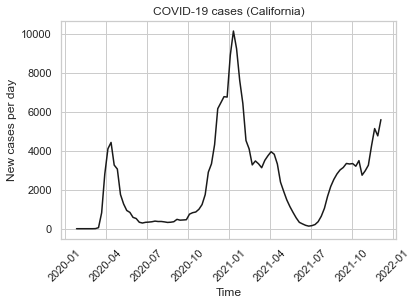

In [1385]:
#Read in COVID case numbers, diff, plot, plot autoregression 

df2 = pd.read_csv('C:\\Users\\Ping\\Desktop\\Project\\COVID_prediction\\data\\United_States_COVID-19_Cases_and_Deaths_by_State_over_Time.csv') 
df2.submission_date=pd.to_datetime(df2.submission_date)
df2.set_index('submission_date', inplace = True)
df2 = df2[df2.state=="NY"]
df2.head()

# Remove commas and make data type int
#df2.new_case = df2.new_case.str.replace(',','').astype('int64', errors = 'raise')

# Aggregate to weekly
new_cases = df2.new_case.resample('W').mean()

plt.plot(new_cases,'k-')
plt.xlabel('Time')
plt.ylabel('New cases per day')
plt.title('COVID-19 cases (California)')
plt.xticks(rotation=45)


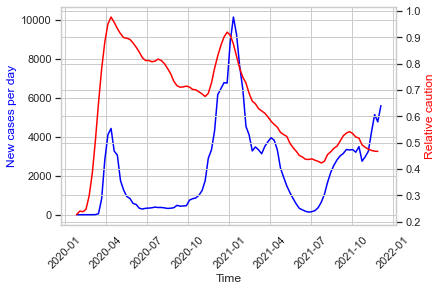

In [1386]:
# Merge the full date range into previous
df_merged = pd.merge(df1,new_cases, how='inner',left_index=True,right_index=True)

# Coplot full range
fig,ax = plt.subplots()
ax.plot(new_cases,color='blue')
ax.set_ylabel('New cases per day',color='blue')
ax.set_xlabel('Time')
plt.xticks(rotation=45)

ax2 = ax.twinx()
ax2.plot(df_merged.caution,color='red')
ax2.set_ylabel('Relative caution',color='red')

plt.show()

fig.savefig('Caution_and_new_cases.png',
            format='png',
            dpi=100,
            bbox_inches='tight')

# Skip initial period of pandemic
df_during = df_merged['2020-04-20':]


C:\Users\Ping\anaconda3\lib\site-packages\pandas\core\generic.py:5168: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


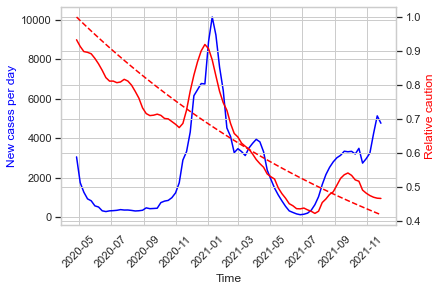

In [1387]:
# Coplot 
fig,ax = plt.subplots()
ax.plot(df_during.new_case,color='blue')
ax.set_ylabel('New cases per day',color='blue')
ax.set_xlabel('Time')
plt.xticks(rotation=45)

ax2 = ax.twinx()
ax2.plot(df_during.caution,color='red')
ax2.set_ylabel('Relative caution',color='red')
                        
t = np.arange(0,len(df_during.caution))
params, cov = curve_fit(func_exp, t, df_during.caution.values)
tau = params
y_fit = func_exp(t, tau)
# Doing a fit with amplitude and offset produces very large coefficients that doesn't reflect asymptoting,
# here we are forcing asymptoting

df_during.caution = df_during.caution-y_fit

ax2.plot(df_during.index, y_fit, color='red',linestyle = '--')

plt.show()

fig.savefig('Caution_and_new_cases.png',
            format='png',
            dpi=100,
            bbox_inches='tight')

C:\Users\Ping\anaconda3\lib\site-packages\pandas\core\indexing.py:1783: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item_labels[indexer[info_axis]]] = value


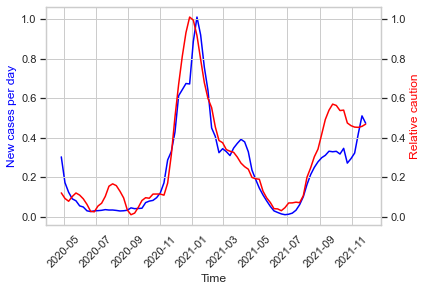

In [1402]:
# Remove down trend from caution
# m, b = np.polyfit(range(0,len(df_during.caution)),df_during.caution, 1)
# tvec = range(0,len(df_during.caution))
# df_during.caution = df_during.caution-(m*tvec+b)

# Max-min normalize
eps = 0.01
df_during.loc[:,'caution']= (df_during.caution-df_during.caution.min())/(df_during.caution.max()-df_during.caution.min())+eps
df_during.loc[:,'new_case']= (df_during.new_case-df_during.new_case.min())/(df_during.new_case.max()-df_during.new_case.min())+eps

fig,ax = plt.subplots()
ax.plot(df_during.new_case,color='blue')
ax.set_ylabel('New cases per day',color='blue')
ax.set_xlabel('Time')
plt.xticks(rotation=45)
#ax.plot(df_during.new_case.diff(),color='black')

ax2 = ax.twinx()
ax2.plot(df_during.caution,color='red')
ax2.set_ylabel('Relative caution',color='red')

plt.show()


In [1403]:
print(sm.tsa.stattools.adfuller(df_during.caution))
print(sm.tsa.stattools.adfuller(df_during.new_case))
# Both will need differencing
print(sm.tsa.stattools.adfuller(df_during.caution.diff().dropna()))
print(sm.tsa.stattools.adfuller(df_during.new_case.diff().dropna()))
# Caution needs a second round of differencing
print(sm.tsa.stattools.adfuller(df_during.caution.diff().diff().dropna()))
print(sm.tsa.stattools.adfuller(df_during.new_case.diff().diff().dropna()))
# Stationary after second order differencing

df_during['log_caution'] = np.log(df_during['caution'])
df_during['log_new_case'] = np.log(df_during['new_case'])
print(sm.tsa.stattools.adfuller(df_during.log_caution))
print(sm.tsa.stattools.adfuller(df_during.log_new_case))

(-2.175042805997577, 0.21542783063667764, 12, 71, {'1%': -3.526004646825607, '5%': -2.9032002348069774, '10%': -2.5889948363419957}, -309.10005361978904)
(-2.181870716369873, 0.2128910117133671, 1, 82, {'1%': -3.512738056978279, '5%': -2.8974898650628984, '10%': -2.585948732897085}, -216.07276045002783)
(-2.372902350289243, 0.14953101596328483, 11, 71, {'1%': -3.526004646825607, '5%': -2.9032002348069774, '10%': -2.5889948363419957}, -299.8142901932028)
(-5.073162434699254, 1.58697037624543e-05, 0, 82, {'1%': -3.512738056978279, '5%': -2.8974898650628984, '10%': -2.585948732897085}, -209.1922895930689)
(-3.706551409551963, 0.004021940739152911, 10, 71, {'1%': -3.526004646825607, '5%': -2.9032002348069774, '10%': -2.5889948363419957}, -290.3802091684838)
(-7.405912804094058, 7.345945660196017e-11, 2, 79, {'1%': -3.5159766913976376, '5%': -2.898885703483903, '10%': -2.5866935058484217}, -192.89615403987875)
(-2.896506622947065, 0.045755740406141936, 10, 73, {'1%': -3.5232835753964475, '5

<ipython-input-1403-da67967568b5>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_during['log_caution'] = np.log(df_during['caution'])
<ipython-input-1403-da67967568b5>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_during['log_new_case'] = np.log(df_during['new_case'])


In [1254]:
pm.plot_acf(df_during.caution)

NameError: name 'pm' is not defined

C:\Users\Ping\anaconda3\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  >>> y = np.require(x, dtype=np.float32, requirements=['A', 'O', 'W', 'F'])


 ARIMA(1,0,2)(0,0,0)[0]             : AIC=29.747, Time=0.13 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=29.726, Time=0.13 sec
 ARIMA(5,0,0)(0,0,0)[0]             : AIC=31.273, Time=0.13 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=56.487, Time=0.08 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=26.991, Time=0.07 sec
 ARIMA(1,0,4)(0,0,0)[0]             : AIC=31.545, Time=0.23 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=31.700, Time=0.22 sec
 ARIMA(4,0,0)(0,0,0)[0]             : AIC=29.609, Time=0.19 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=53.321, Time=0.11 sec
 ARIMA(4,0,1)(0,0,0)[0]             : AIC=30.023, Time=0.39 sec
 ARIMA(0,0,4)(0,0,0)[0]             : AIC=29.519, Time=0.16 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=36.869, Time=0.11 sec
 ARIMA(0,0,5)(0,0,0)[0]             : AIC=inf, Time=0.37 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=28.188, Time=0.25 sec
 ARIMA(1,0,3)(0,0,0)[0]             : AIC=27.120, Time=0.30 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=3

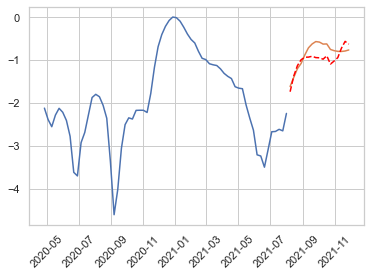

In [1412]:
train, test = df_during[0:round(0.8*(len(df_during.log_caution)))], df_during[round(0.8*(len(df_during.log_caution))):]

model = auto_arima(df_during.log_caution,start_p=3, d=0, start_q=1, seasonal=False, trace=1, 
                   exogenous=np.reshape(df_during.log_new_case.values,(-1,1)),
                   stepwise=False, random=True, n_fits=50, random_state=0)
model.summary()

model.fit(train.log_caution, exogenous=np.reshape(train.log_new_case.values,(-1,1)))
forecast = model.predict(exogenous=np.reshape(test.log_new_case.values,(-1,1)), n_periods=len(test))

forecast = pd.DataFrame(forecast,index = test.index,columns=['log_caution_pred'])
forecast = pd.concat([test,forecast],axis=1)
plt.plot(train.log_caution)
plt.plot(forecast.log_caution)
plt.plot(forecast.log_caution_pred, color='red',linestyle='--')
plt.xticks(rotation=45)
plt.show()

# Selects (2,1,2) and stable around (2,1,2) for CA
# Chooses (1,2,2) for NY

In [1405]:
train, test = df_during[0:round(0.8*(len(df_during.caution)))], df_during[round(0.8*(len(df_during.caution))):]

model = auto_arima(df_during.caution,start_p=3, d=2, start_q=1, seasonal=False, trace=1, 
                   stepwise=False, random=True, n_fits=50, random_state=0)

# Selects (2,1,2) and stable around (2,1,2) for CA
# Chooses (1,2,2) for NY


C:\Users\Ping\anaconda3\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  >>> y = np.require(x, dtype=np.float32, requirements=['A', 'O', 'W', 'F'])


 ARIMA(1,0,2)(0,0,0)[0]             : AIC=-320.741, Time=0.34 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=-340.405, Time=0.13 sec
 ARIMA(5,0,0)(0,0,0)[0]             : AIC=-342.416, Time=0.26 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=-28.904, Time=0.05 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=-340.744, Time=0.07 sec
 ARIMA(1,0,4)(0,0,0)[0]             : AIC=-339.039, Time=0.27 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=-341.054, Time=0.26 sec
 ARIMA(4,0,0)(0,0,0)[0]             : AIC=-341.676, Time=0.24 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.05 sec
 ARIMA(4,0,1)(0,0,0)[0]             : AIC=-338.890, Time=0.32 sec
 ARIMA(0,0,4)(0,0,0)[0]             : AIC=inf, Time=0.30 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=inf, Time=0.19 sec
 ARIMA(0,0,5)(0,0,0)[0]             : AIC=inf, Time=0.34 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=-341.758, Time=0.19 sec
 ARIMA(1,0,3)(0,0,0)[0]             : AIC=inf, Time=0.32 sec
 ARIMA(1,0,1)(0,0,0)[0]             

In [1365]:
model = auto_arima(df_during.caution, start_p=2, d=2, start_q=2, exogenous=np.reshape(df_during.new_case.values,(-1,1)),
                   trace=1, seasonal= False, stepwise=False, random=True, n_fits=30, random_state=0) 
model.fit(train.caution, exogenous=np.reshape(train.new_case.values,(-1,1)))
forecast = model.predict(exogenous=np.reshape(test.new_case.values,(-1,1)), n_periods=len(test))

model.summary()
# Chooses () for CA
# Chooses (1,2,4) for NY

C:\Users\Ping\anaconda3\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  >>> y = np.require(x, dtype=np.float32, requirements=['A', 'O', 'W', 'F'])


 ARIMA(1,2,2)(0,0,0)[0] intercept   : AIC=-395.659, Time=0.40 sec
 ARIMA(2,2,2)(0,0,0)[0] intercept   : AIC=-392.613, Time=0.49 sec
 ARIMA(5,2,0)(0,0,0)[0] intercept   : AIC=-393.905, Time=0.47 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=-398.246, Time=0.08 sec
 ARIMA(2,2,0)(0,0,0)[0] intercept   : AIC=-396.203, Time=0.29 sec
 ARIMA(1,2,4)(0,0,0)[0] intercept   : AIC=-399.142, Time=0.47 sec
 ARIMA(2,2,3)(0,0,0)[0] intercept   : AIC=-390.881, Time=0.45 sec
 ARIMA(4,2,0)(0,0,0)[0] intercept   : AIC=-395.352, Time=0.18 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=-398.172, Time=0.08 sec
 ARIMA(4,2,1)(0,0,0)[0] intercept   : AIC=-398.238, Time=0.45 sec
 ARIMA(0,2,4)(0,0,0)[0] intercept   : AIC=inf, Time=0.47 sec
 ARIMA(0,2,2)(0,0,0)[0] intercept   : AIC=-396.292, Time=0.23 sec
 ARIMA(0,2,5)(0,0,0)[0] intercept   : AIC=inf, Time=0.55 sec
 ARIMA(3,2,1)(0,0,0)[0] intercept   : AIC=-393.104, Time=0.40 sec
 ARIMA(1,2,3)(0,0,0)[0] intercept   : AIC=-392.867, Time=0.34 sec
 ARIMA(1,2,1)(0,0,0)

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   67
Model:               SARIMAX(1, 2, 4)   Log Likelihood                 166.899
Date:                Sat, 04 Dec 2021   AIC                           -317.797
Time:                        23:20:46   BIC                           -300.402
Sample:                             0   HQIC                          -310.934
                                 - 67                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   6.224e-05      0.000      0.134      0.893      -0.001       0.001
x1            -0.0305      0.025     -1.228      0.219      -0.079       0.018
ar.L1          0.6436      0.440      1.464      0.143      -0.218       1.505
ma.L1         -0.3321      0.432     -0.770      0.442      -1.178       0.514
ma.L2         -0.3311      0.219     -1.512      0.131      -0.760       0.098
ma.L3          0.0361      0.211      0.171      0.864      -0.377       0.449
ma.L4         -0.2246      0.218     -1.032      0.302      -0.651       0.202
sigma2         0.0003   8.41e-05      4.036      0.000       0.000       0.001
===================================================================================
Ljung-Box (L1) (Q):                   0.11   Jarque-Bera (JB):                 0.16
Prob(Q):                              0.74   Prob(JB):                         0.92
Heteroskedasticity (H):               1.39   Skew:                            -0.03
Prob(H) (two-sided):                  0.45   Kurtosis:                         3.24
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

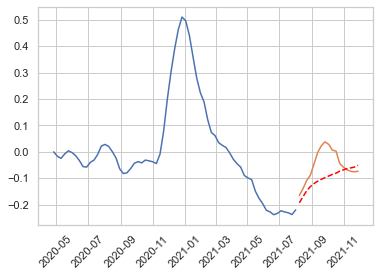

665.7094575680687

In [1366]:
forecast = pd.DataFrame(forecast,index = test.index,columns=['caution_pred'])
forecast = pd.concat([test,forecast],axis=1)
plt.plot(train.caution)
plt.plot(forecast.caution)
plt.plot(forecast.caution_pred, color='red',linestyle='--')
plt.xticks(rotation=45)
plt.show()

mape(forecast.caution, forecast.caution_pred)

In [1340]:
model = auto_arima(df_during.new_case, start_p=2, d=2, start_q=2, exogenous=np.reshape(df_during.caution.values,(-1,1)),
                   trace=1, seasonal= False, stepwise=False, random=True, n_fits=30, random_state=0) 
model.fit(train.new_case, exogenous=np.reshape(train.caution.values,(-1,1)))
forecast = model.predict(exogenous=np.reshape(test.caution.values,(-1,1)), n_periods=len(test))

C:\Users\Ping\anaconda3\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  >>> y = np.require(x, dtype=np.float32, requirements=['A', 'O', 'W', 'F'])


 ARIMA(1,2,2)(0,0,0)[0] intercept   : AIC=-250.809, Time=0.44 sec
 ARIMA(2,2,2)(0,0,0)[0] intercept   : AIC=-248.052, Time=0.44 sec
 ARIMA(5,2,0)(0,0,0)[0] intercept   : AIC=-239.229, Time=0.45 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.33 sec
 ARIMA(2,2,0)(0,0,0)[0] intercept   : AIC=-235.660, Time=0.17 sec
 ARIMA(1,2,4)(0,0,0)[0] intercept   : AIC=-247.342, Time=0.50 sec
 ARIMA(2,2,3)(0,0,0)[0] intercept   : AIC=-251.231, Time=0.45 sec
 ARIMA(4,2,0)(0,0,0)[0] intercept   : AIC=-240.928, Time=0.27 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=-235.661, Time=0.11 sec
 ARIMA(4,2,1)(0,0,0)[0] intercept   : AIC=-241.389, Time=0.42 sec
 ARIMA(0,2,4)(0,0,0)[0] intercept   : AIC=-248.674, Time=0.37 sec
 ARIMA(0,2,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.27 sec
 ARIMA(0,2,5)(0,0,0)[0] intercept   : AIC=-252.158, Time=0.50 sec
 ARIMA(3,2,1)(0,0,0)[0] intercept   : AIC=-248.578, Time=0.33 sec
 ARIMA(1,2,3)(0,0,0)[0] intercept   : AIC=-249.129, Time=0.53 sec
 ARIMA(1,2,1)(0,0,0)

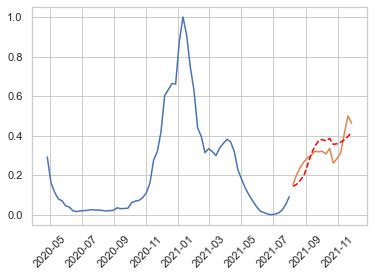

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   67
Model:               SARIMAX(0, 2, 5)   Log Likelihood                 102.054
Date:                Sat, 04 Dec 2021   AIC                           -188.107
Time:                        22:31:01   BIC                           -170.712
Sample:                             0   HQIC                          -181.244
                                 - 67                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0006      0.002      0.372      0.710      -0.003       0.004
x1             0.9816      0.132      7.453      0.000       0.724       1.240
ma.L1         -0.5247      0.179     -2.925      0.003      -0.876      -0.173
ma.L2         -0.3364      0.132     -2.558      0.011      -0.594      -0.079
ma.L3         -0.5179      0.111     -4.673      0.000      -0.735      -0.301
ma.L4          0.2008      0.223      0.900      0.368      -0.237       0.638
ma.L5          0.3441      0.206      1.671      0.095      -0.060       0.748
sigma2         0.0024      0.000      5.677      0.000       0.002       0.003
===================================================================================
Ljung-Box (L1) (Q):                   0.29   Jarque-Bera (JB):               104.13
Prob(Q):                              0.59   Prob(JB):                         0.00
Heteroskedasticity (H):               0.48   Skew:                            -0.95
Prob(H) (two-sided):                  0.09   Kurtosis:                         8.90
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [1329]:
forecast = pd.DataFrame(forecast,index = test.index,columns=['new_case_pred'])
forecast = pd.concat([test,forecast],axis=1)
plt.plot(train.new_case)
plt.plot(forecast.new_case)
plt.plot(forecast.new_case_pred, color='red',linestyle='--')
plt.xticks(rotation=45)
plt.show()

model.summary()

In [ ]:
# Forecast next two weeks - don't forget to put exponential trend back in

In [1230]:
fit2 = ARIMA(endog=train.caution, exog=train.new_case, order=(2,1,1))
fit2.fit()
#fc = fit2.predict(len(test.new_case), exog=test.new_case)


C:\Users\Ping\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  raise ValueError('Non-date index index provided to'
C:\Users\Ping\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  raise ValueError('Non-date index index provided to'
C:\Users\Ping\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  raise ValueError('Non-date index index provided to'


<ipython-input-1341-2870e99ab165>:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_during['new_case_sta'] = df_during.new_case.diff().diff()


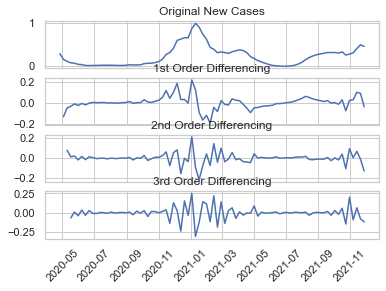

In [1341]:
# Make stationary with differencing

fig, axes = plt.subplots(4, 1, sharex=True)
axes[0].plot(df_during.new_case); axes[0].set_title('Original New Cases')

# 1st Differencing
axes[1].plot(df_during.new_case.diff()); axes[1].set_title('1st Order Differencing')

# 2nd Differencing
axes[2].plot(df_during.new_case.diff().diff()); axes[2].set_title('2nd Order Differencing')

# 3rd Differencing
axes[3].plot(df_during.new_case.diff().diff().diff()); axes[3].set_title('3rd Order Differencing')
plt.xticks(rotation=45)

# Autocorrelogram on new cases
#plot_acf(df.value, ax=axes[0, 1])
#plot_acf(df.value.diff().dropna(), ax=axes[1, 1])
#plot_acf(df.value.diff().diff().dropna(), ax=axes[2, 1])

result = adfuller(df_during.new_case.diff().diff().dropna())
result
# result[0] is test statistic, result[1] is p-val
# p-val < 0.05, so time series is stationary enough after one round of differencing, value gets smaller with more rounds
# visually looks reasonable after 2 rounds, no better with 3 rounds

df_during['new_case_sta'] = df_during.new_case.diff().diff()

<ipython-input-1342-8d621712e138>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_during['caution_sta'] = df_during.caution.diff().diff()


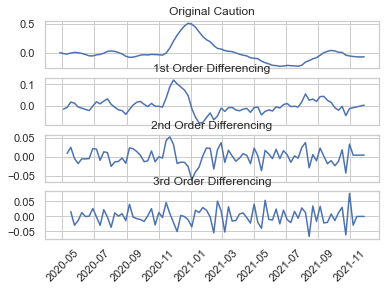

In [1342]:
fig, axes = plt.subplots(4, 1, sharex=True)
axes[0].plot(df_during.caution); axes[0].set_title('Original Caution')

# 1st Differencing
axes[1].plot(df_during.caution.diff()); axes[1].set_title('1st Order Differencing')

# 2nd Differencing
axes[2].plot(df_during.caution.diff().diff()); axes[2].set_title('2nd Order Differencing')

# 3rd Differencing
axes[3].plot(df_during.caution.diff().diff().diff()); axes[3].set_title('3rd Order Differencing')
plt.xticks(rotation=45)

result = adfuller(df_during.caution.diff().diff().dropna())
result

df_during['caution_sta'] = df_during.caution.diff().diff()

In [1361]:
df_during2 = df_during.dropna()     # creating this helps indices stay in sync
df_sta = df_during2[['new_case_sta','caution_sta']]
train, test = df_sta[0:round(0.8*(len(df_sta.caution_sta)))], df_sta[round(0.8*(len(df_sta.caution_sta))):]
print(train.shape, test.shape)

for i in range(1,9):
    model = VAR(endog=train)
    model_fit = model.fit(i)
    print('maxlag :',i)
    print('AIC : ', model_fit.aic)

model_fit = model.fit(maxlags=8, ic='aic',verbose='true')
    
lag_order = model_fit.k_ar 

#model_fit = model.fit(lag_order)
model_fit = model.fit(lag_order)
model_fit.summary()



(66, 2) (16, 2)
maxlag : 1
AIC :  -13.499940352177042
maxlag : 2
AIC :  -13.429478561117559
maxlag : 3
AIC :  -13.404114915871313
maxlag : 4
AIC :  -13.411423256537425
maxlag : 5
AIC :  -13.359003544020217
maxlag : 6
AIC :  -13.353885090364779
maxlag : 7
AIC :  -13.505082730204208
maxlag : 8
AIC :  -13.460821825454378
<statsmodels.tsa.vector_ar.var_model.LagOrderResults object. Selected orders are: AIC -> 7, BIC -> 0, FPE -> 7, HQIC -> 1>
Using 7 based on aic criterion


C:\Users\Ping\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  raise ValueError('Non-date index index provided to'
C:\Users\Ping\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  raise ValueError('Non-date index index provided to'
C:\Users\Ping\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  raise ValueError('Non-date index index provided to'
C:\Users\Ping\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  raise ValueError('Non-date index index provided to'
C:\Users\Ping\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524:

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sat, 04, Dec, 2021
Time:                     23:13:31
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                   -12.4487
Nobs:                     59.0000    HQIC:                  -13.0927
Log likelihood:           260.965    FPE:                1.39547e-06
AIC:                     -13.5051    Det(Omega_mle):     8.87075e-07
--------------------------------------------------------------------
Results for equation new_case_sta
                     coefficient       std. error           t-stat            prob
----------------------------------------------------------------------------------
const                   0.002687         0.006318            0.425           0.671
L1.new_case_sta        -0.566841         0.133037           -4.261           0.000
L1.caution_sta          1.067697         0.36

<ipython-input-1357-bbbfded00b78>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['new_case_fc']=df_fc['new_case_sta_fc']
<ipython-input-1357-bbbfded00b78>:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['caution_fc']=df_fc['caution_sta_fc']


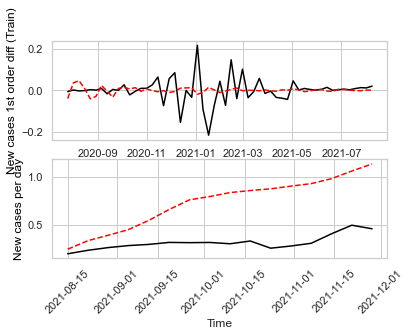

In [1357]:
start = 0
forecast_input = train.values[start:start+lag_order]
fc_train = model_fit.forecast(forecast_input, steps=len(train)-start-lag_order)
df_fc_train = pd.DataFrame(fc_train, index = df_sta.index[start+lag_order:len(train)], columns = df_sta.columns + '_fc')
df_fc_train['new_case_sta'] = train.values[start+lag_order:,0]

forecast_input2 = train.values[-lag_order:]
fc = model_fit.forecast(y=forecast_input2, steps=len(test))
df_forecast = pd.DataFrame(fc, index=df_sta.index[-len(test):], columns=df_sta.columns + '_2d')

df_fc = df_forecast.copy()
columns = df_sta.columns

for col in columns: 
    col_orig = col.replace("_sta","")
    # De-difference 2nd
    df_fc[str(col)+'_1d'] = (df_during2[col_orig].iloc[len(train)-1]-df_during2[col_orig].iloc[len(train)-2]) + df_fc[str(col)+'_2d'].cumsum()
    
    # De-difference again
    df_fc[str(col)+'_fc'] = df_during2[col_orig].iloc[len(train)-1] + df_fc[str(col)+'_1d'].cumsum()

# Check
    df_check['new_case_1d'] = (df_during2['new_case'].iloc[len(train)-1]-df_during2['new_case'].iloc[len(train)-2]) + test["new_case_sta"].cumsum()
   
    df_check['new_case'] = df_during2['new_case'].iloc[len(train)-1] + df_check["new_case_1d"].cumsum()


test['new_case_fc']=df_fc['new_case_sta_fc']
test['caution_fc']=df_fc['caution_sta_fc']

fig,ax = plt.subplots(2,1)

ax[0].plot(df_fc_train.new_case_sta,color='black')
ax[0].set_ylabel('New cases 1st order diff (Train)',color='black')
ax[0].set_xlabel('Time')
ax[0].plot(df_fc_train.new_case_sta_fc,color='red',linestyle='--')

ax[1].plot(df_during2.new_case[round(0.8*(len(df_sta.caution_sta))):],color='black')
ax[1].set_ylabel('New cases per day',color='black')
ax[1].set_xlabel('Time')
plt.xticks(rotation=45)

ax[1].plot(test.new_case_fc,color='red',linestyle='--')
plt.show()


In [926]:
mape(df_during2.new_case[round(0.9*(len(df_sta.caution_sta))):], test.new_case_fc)

57.907524306296054

In [1240]:
df_during_sub = df_during[['new_case','caution']].dropna()
train, test = df_during_sub[0:round(0.85*(len(df_during_sub.caution)))], df_during_sub[round(0.85*(len(df_during_sub.caution))):]
print(train.shape, test.shape)

model = VAR(endog=train)
model_fit = model.fit(maxlags=8, ic='aic',verbose='true',trend='ct')

lag_order = model_fit.k_ar  
#lag order 5 was selected
model_fit.summary()

(70, 2) (12, 2)
<statsmodels.tsa.vector_ar.var_model.LagOrderResults object. Selected orders are: AIC -> 2, BIC -> 2, FPE -> 2, HQIC -> 2>
Using 2 based on aic criterion


C:\Users\Ping\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  raise ValueError('Non-date index index provided to'


  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sat, 04, Dec, 2021
Time:                     18:06:41
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                   -11.2606
Nobs:                     68.0000    HQIC:                  -11.4971
Log likelihood:           215.201    FPE:                8.70739e-06
AIC:                     -11.6523    Det(Omega_mle):     7.35262e-06
--------------------------------------------------------------------
Results for equation new_case
                 coefficient       std. error           t-stat            prob
------------------------------------------------------------------------------
const               0.039404         0.014619            2.695           0.007
trend               0.000568         0.000321            1.770           0.077
L1.new_case         1.429777         0.101511           14.085   

<ipython-input-1241-9627fd7ca4fe>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['new_case_fc']=fc[:,0]
<ipython-input-1241-9627fd7ca4fe>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['caution_fc']=fc[:,1]


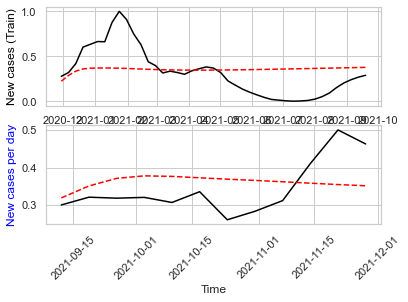

In [1241]:
start = 25
forecast_input = train.values[start:start+lag_order]
fc_train = model_fit.forecast(forecast_input, steps=len(train)-start-lag_order)
df_fc_train = pd.DataFrame(fc_train, index = df_sta.index[start+lag_order:len(train)], columns = df_sta.columns + '_fc')
df_fc_train['new_case'] = train.values[start+lag_order:,0]

forecast_input2 = train.values[-lag_order:]
fc = model_fit.forecast(forecast_input2, steps=len(test.new_case))
test['new_case_fc']=fc[:,0]
test['caution_fc']=fc[:,1]

fig,ax = plt.subplots(2,1)

ax[0].plot(df_fc_train.new_case,color='black')
ax[0].set_ylabel('New cases (Train)',color='black')
ax[0].set_xlabel('Time')
ax[0].plot(df_fc_train.new_case_sta_fc,color='red',linestyle='--')

ax[1].plot(test.new_case,color='black')
ax[1].set_ylabel('New cases per day',color='blue')
ax[1].set_xlabel('Time')
plt.xticks(rotation=45)

ax[1].plot(test.new_case_fc,color='red',linestyle='--')
plt.show()


In [929]:
mape(test.new_case, test.new_case_fc)


45.67397032473607

C:\Users\Ping\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  raise ValueError('Non-date index index provided to'


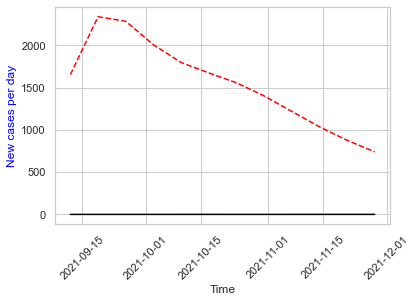

In [1242]:
model2 = sm.tsa.VARMAX(endog=train, order = (2,0), trend='ct')
model2_fit = model2.fit(maxiter=5000, disp=True)
model2_fit.summary()

# Does not converge for 5, works horribly for other values

# Only can forecast from end of sample
fc = model2_fit.forecast(steps=len(test.new_case))

fig,ax = plt.subplots()

ax.plot(test.new_case,color='black')
ax.set_ylabel('New cases per day',color='blue')
ax.set_xlabel('Time')
plt.xticks(rotation=45)

ax.plot(fc.new_case,color='red',linestyle='--')
plt.show()


In [1305]:
df_during = df_during.dropna()

grangercausalitytests(df_during[['caution_sta','new_case_sta']],maxlag=12)

# Case levels predict caution


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.4532  , p=0.5028  , df_denom=78, df_num=1
ssr based chi2 test:   chi2=0.4707  , p=0.4927  , df=1
likelihood ratio test: chi2=0.4693  , p=0.4933  , df=1
parameter F test:         F=0.4532  , p=0.5028  , df_denom=78, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.3668  , p=0.6942  , df_denom=75, df_num=2
ssr based chi2 test:   chi2=0.7825  , p=0.6762  , df=2
likelihood ratio test: chi2=0.7787  , p=0.6775  , df=2
parameter F test:         F=0.3668  , p=0.6942  , df_denom=75, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.2815  , p=0.8386  , df_denom=72, df_num=3
ssr based chi2 test:   chi2=0.9265  , p=0.8190  , df=3
likelihood ratio test: chi2=0.9211  , p=0.8203  , df=3
parameter F test:         F=0.2815  , p=0.8386  , df_denom=72, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=1.2430  , p=0.3009  , df_d

{1: ({'ssr_ftest': (0.4532311553272883, 0.5027943958814369, 78.0, 1),
   'ssr_chi2test': (0.47066312283987627, 0.49268225913545927, 1),
   'lrtest': (0.4693009662636314, 0.49330893261786923, 1),
   'params_ftest': (0.453231155327281, 0.5027943958814369, 78.0, 1.0)},
   array([[0., 1., 0.]])]),
 2: ({'ssr_ftest': (0.3668022643166008, 0.6941827958918997, 75.0, 2),
   'ssr_chi2test': (0.7825114972087484, 0.6762071948765866, 2),
   'lrtest': (0.7787092448013482, 0.6774939728700129, 2),
   'params_ftest': (0.36680226431660556, 0.6941827958918997, 75.0, 2.0)},
   array([[0., 0., 1., 0., 0.],
          [0., 0., 0., 1., 0.]])]),
 3: ({'ssr_ftest': (0.2814574139090828, 0.8386160075870405, 72.0, 3),
   'ssr_chi2test': (0.9264639874507308, 0.8190371958834449, 3),
   'lrtest': (0.9210735867908397, 0.8203395185638472, 3),
   'params_ftest': (0.28145741390908735, 0.8386160075870366, 72.0, 3.0)},
   array([[0., 0., 0., 1., 0., 0., 0.],
          [0., 0., 0., 0., 1., 0., 0.],
          [0., 0., 0., 0.

In [1306]:
grangercausalitytests(df_during[['new_case_sta','caution_sta']],maxlag=12)

# Caution predicts case loads only for lag 1, trends towards significance again at lag 5-6


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.4645  , p=0.1205  , df_denom=78, df_num=1
ssr based chi2 test:   chi2=2.5592  , p=0.1097  , df=1
likelihood ratio test: chi2=2.5196  , p=0.1124  , df=1
parameter F test:         F=2.4645  , p=0.1205  , df_denom=78, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=3.3338  , p=0.0410  , df_denom=75, df_num=2
ssr based chi2 test:   chi2=7.1120  , p=0.0286  , df=2
likelihood ratio test: chi2=6.8134  , p=0.0331  , df=2
parameter F test:         F=3.3338  , p=0.0410  , df_denom=75, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=2.9896  , p=0.0366  , df_denom=72, df_num=3
ssr based chi2 test:   chi2=9.8409  , p=0.0200  , df=3
likelihood ratio test: chi2=9.2745  , p=0.0259  , df=3
parameter F test:         F=2.9896  , p=0.0366  , df_denom=72, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=2.2522  , p=0.0723  , df_d

{1: ({'ssr_ftest': (2.4644513772735617, 0.12049639809312873, 78.0, 1),
   'ssr_chi2test': (2.5592379687071602, 0.10965142561439921, 1),
   'lrtest': (2.5196396547288487, 0.11243627513583487, 1),
   'params_ftest': (2.4644513772735444, 0.12049639809313037, 78.0, 1.0)},
   array([[0., 1., 0.]])]),
 2: ({'ssr_ftest': (3.333750338435535, 0.0410156829403812, 75.0, 2),
   'ssr_chi2test': (7.112000721995808, 0.028552797519788092, 2),
   'lrtest': (6.813441652640847, 0.03314972605052122, 2),
   'params_ftest': (3.3337503384355376, 0.0410156829403812, 75.0, 2.0)},
   array([[0., 0., 1., 0., 0.],
          [0., 0., 0., 1., 0.]])]),
 3: ({'ssr_ftest': (2.989627840815544, 0.03655927881939271, 72.0, 3),
   'ssr_chi2test': (9.840858309351166, 0.01996848329956033, 3),
   'lrtest': (9.27450581670928, 0.025855288601887152, 3),
   'params_ftest': (2.9896278408155443, 0.03655927881939271, 72.0, 3.0)},
   array([[0., 0., 0., 1., 0., 0., 0.],
          [0., 0., 0., 0., 1., 0., 0.],
          [0., 0., 0., 0

In [ ]:
plt_acf(dataset[i], lags = 50)
  plt.title('ACF for %s' % i)